In [319]:
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt
import xarray as xr
from scipy.stats import halfnorm

In [448]:
df = pd.read_csv('dataset.csv')

In [449]:
df

,project,language,commits,insertions,age,bugs,project_type,devs
0,4clojure,Clojure,629,9180,774,128,Application,21
1,4clojure,Javascript,75,39240,509,29,Application,10
2,AFIncrementalStore,Objective-C,196,5624,362,74,Library,24
3,AFNetworking,Objective-C,952,50099,962,403,Framework,128
4,ActionBar-PullToRefresh,Java,213,14657,192,68,Library,5
...,...,...,...,...,...,...,...,...
1122,zipkin,Scala,245,54100,589,207,Application,8
1123,zombie,Coffeescript,731,52668,1060,181,Framework,65
1124,zombie,Javascript,46,172564,1026,7,Framework,7
1125,zxcvbn,Coffeescript,58,2085,341,11,Library,5


We define the dataset as an xarray aswell, so it fits PyMC.

In [76]:
df_xa = df.to_xarray()

In [106]:
df['prop'] = df['bugs'] / df['commits']

In [110]:
df.groupby('language')['prop'].mean()

language
C               0.337587
C#              0.293603
C++             0.359173
Clojure         0.194277
Coffeescript    0.276535
Erlang          0.281492
Go              0.224597
Haskell         0.209834
Java            0.275306
Javascript      0.290881
Objective-C     0.325213
Perl            0.238437
Php             0.335931
Python          0.303400
Ruby            0.252835
Scala           0.225063
Typescript      0.181987
Name: prop, dtype: float64

In [77]:
RANDOM_SEED = 8927
RNG = np.random.default_rng(RANDOM_SEED)

## Helper Functions

In [78]:
def standardize_column(column):
    '''
    Transforms column by its z-score.
    '''
    standardized_column = (column - column.mean()) / column.std()
    
    return standardized_column

In [79]:
def transform_exp(x):
    '''
    Transform a value to its exponential value. 
    '''
    return np.exp(x)

## Hypothesis 1

* **H1** - Haskell code is less prone to contain bugs (B). In other words, the distribution on the number of bugs (B) for Haskell gives high probability to the lowest number of bugs among all programming languages (L).

In [80]:
df.groupby('language').size()

language
C                82
C#               51
C++              86
Clojure          50
Coffeescript     52
Erlang           42
Go               38
Haskell          39
Java             74
Javascript      202
Objective-C      56
Perl             25
Php              57
Python          102
Ruby             67
Scala            46
Typescript       58
dtype: int64

Since the outcome variable Bugs $B$ is an unbounded count, we model it with a Poisson distribution.

$$
B_i \sim \mathrm{Poisson}(\lambda_i)
$$

This means that the log-link function is used to connect $B$ to the predictors. We treat programming language $L$ as a categorical nominal predictor with 17 levels. We also add an intercept $\alpha$.

$$
log(\lambda_i) = \alpha + \beta_{L[i]}
$$

The priors for $\alpha$ and $\beta_{L[i]}$ are not yet defined. In the following sections we determine reasonable priors for them.
$$
\alpha = \text{Not determined yet}
$$

$$
\beta_{L[i]} = \text{Not determined yet}
$$





#### Determine prior for $\beta_{L[i]}$ 

Next we determine priors for $\beta_{L[i]}$.  

We simulate the effect of varying the prior for $\beta_{L[i]}$ by sampling N alphas with a fixed prior, and sampling N betas where we can determine the prior.

We then plot the effect only including the intercept $\alpha$ (0) and then including both $\alpha$ and $\beta_{L[i]}$ (1). This creates a line that corresponds to the effect of adding a language as a predictor.

In [84]:
def plot_prior_categorical(b_mean: int = 1, b_std: int = 1, N: int = 100):
    plt.figure()
        
    alphas = np.random.normal(6, 1.1, N)
    betas = np.random.normal(b_mean, b_std, N)
    
    # Plot each line
    for a, b in zip(alphas, betas):
        x_seq = np.array([0, 1])
        plt.plot(x_seq, np.exp(a + b * x_seq), 'k', alpha=0.4)

    plt.xticks([0, 1])
    plt.xlabel("Language")
    plt.ylabel('Number of bugs')
    
    return plt

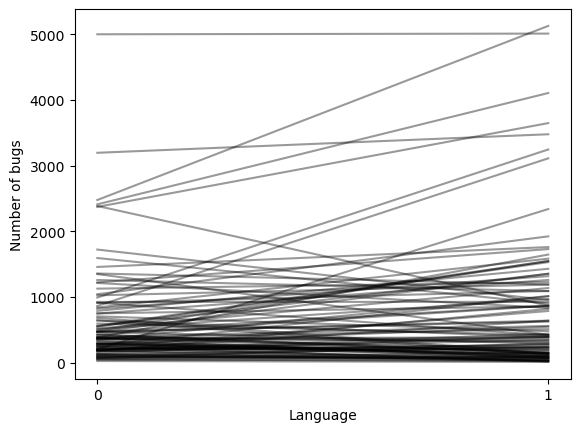

In [162]:
plot_prior_categorical(0, 1);

These effects of language seem plausible. They allow for both positive and negative impact of language on the number of bugs. Many of them are rather flat, representing a conservative prior, meaning that we dont expect a particular direction of the effect of language. There are 17 different languages and some of them might have a positive impact on the number of bugs, whereas others might have a negative impact. We want the prior for the effect of language to reflect this, since we only determine a single prior for all languages.


We therefore define the prior for $\beta_{L[i]}$ to be $\mathrm{Normal}(0, 1)$.

#### Fit model

We factorise the language column, so it can fit in the model.

In [90]:
language_idx, languages = pd.factorize(df.language)
project_type_idx, project_types = pd.factorize(df.project_type)

In [94]:
def create_model_h1(alpha_mu_prior, alpha_sigma_prior, beta_mu_prior, beta_sigma_prior, save_name='', save=False):
  '''
  Creates model for hypothesis 1. 
  '''
  with pm.Model() as model:
      # Priors
      alpha = pm.Normal("alpha", mu=alpha_mu_prior, sigma=alpha_sigma_prior)
      beta_language = pm.Normal('beta_language',  mu=beta_mu_prior, sigma=beta_sigma_prior, shape=languages.size)
      beta_project_type = pm.Normal('beta_project_type',  mu=beta_mu_prior, sigma=beta_sigma_prior, shape=project_types.size)
      
      #We add language_ids as mutable data so we can change it later in posterior predictions
      language_ids = pm.Data('language_ids', language_idx, mutable=True)
      project_type_ids = pm.Data('project_type_ids', project_type_idx, mutable=True)

      lam = pm.Deterministic('lam', pm.math.exp(alpha + beta_language[language_ids] + beta_project_type[project_type_ids]))
      B = pm.Poisson('B', mu=lam, observed=df.bugs)
      
      #Sample posterior and prior predictive
      trace = pm.sample(2000, tune=1000, idata_kwargs={'log_likelihood': True}, chains=4)
    
      if save == True:  
        trace.to_netcdf("./traces/"+save_name+"_.nc")

  return trace, model

In [95]:
h1_idata, h1_model = create_model_h1(6, 1.3, 0, 1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_language, beta_project_type]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 437 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


We plot the structure of the model below. The model has one $\alpha$ and one $\beta$ for every language (17 total). It also has 1.127 observations of number of bugs (B).

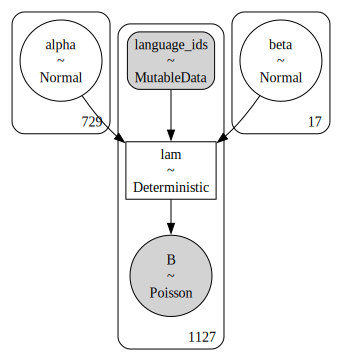

In [27]:
pm.model_to_graphviz(model=h1_model)

**THIS TEXT IS A DRAFT AND NOT CHANGED FOR THE RESULTS**

Below is the trace convergence for the parameters `alpha` and `beta`.

The number of generated samples is 4 chains * 2000 samples = 8000 samples.

The effective sample sizes (`ess_bulk`, `ess_tail`) approach the number of generated samples, which indicates that the samples both in the bulk and in the tails of the posteriors have low-autocorrelation. This means most of the generated samples are sufficiently different from the previous sample, thereby adding information about the posterior, leading to high accuracy of each chain.


We also note that the Monte Carlo Standard Error `msce_mean` and `msce_sd` are $0.0$, which also indicates good accuracy in the chains.

In addition, both the rhat values `r_hat` are $1.0$, which means that the 4 chains have converged well. This is also reflected in the plot below, which shows good mixing of the chains.

In summary, the convergence of the trace for model 2 is good and shows no signs of inefficient of inaccuracte sampling. We can therefore use the posterior distributions with high confidence.

In [28]:
#specifying names of the variables
var_names_langauge = list(h1_idata.posterior.data_vars.keys())[:-1]
pm.summary(h1_idata, var_names=var_names_langauge,round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],5.06,0.10,4.88,5.26,0.01,0.01,122.29,1262.64,1.03
alpha[1],6.39,0.13,6.15,6.64,0.01,0.01,148.99,2044.20,1.02
alpha[2],8.09,0.07,7.97,8.22,0.01,0.01,29.22,92.53,1.09
alpha[3],4.73,0.13,4.48,4.97,0.01,0.01,104.70,1919.01,1.03
alpha[4],5.56,0.09,5.38,5.72,0.01,0.01,45.17,229.27,1.06
...,...,...,...,...,...,...,...,...,...
beta[12],-1.32,0.05,-1.41,-1.23,0.01,0.01,12.17,26.77,1.25
beta[13],-2.34,0.05,-2.43,-2.25,0.01,0.01,14.09,37.20,1.21
beta[14],-3.13,0.04,-3.22,-3.04,0.01,0.01,11.48,24.56,1.27
beta[15],-0.55,0.07,-0.67,-0.42,0.01,0.01,27.61,164.68,1.10


In [101]:
df[df['project_type']=="Middleware"]

,project,language,commits,insertions,age,bugs,project_type,devs
36,DesignPatternsPHP,Php,197,8047,838,20,Middleware,26
63,IHaskell,Haskell,212,41309,144,49,Middleware,4
88,MetroLog,C#,63,20755,402,12,Middleware,4
114,PaperFold-for-iOS,Objective-C,91,6012,505,32,Middleware,10
126,ProjectTox-Core,C,965,71533,210,377,Middleware,90
...,...,...,...,...,...,...,...,...
1086,websocketd,Go,45,3427,309,10,Middleware,6
1087,whenever,Ruby,185,7539,1766,38,Middleware,31
1089,wp-svbtle,Php,195,20623,427,119,Middleware,27
1104,yaws,C,46,2246,4225,17,Middleware,6


In [105]:
df.groupby('project_type')['language'].value_counts()

project_type  language    
Application   Javascript      38
              C++             32
              Python          22
              Typescript      21
              Coffeescript    14
                              ..
Other         Coffeescript     2
              Php              2
              Go               2
              C#               2
              Clojure          1
Name: count, Length: 116, dtype: int64

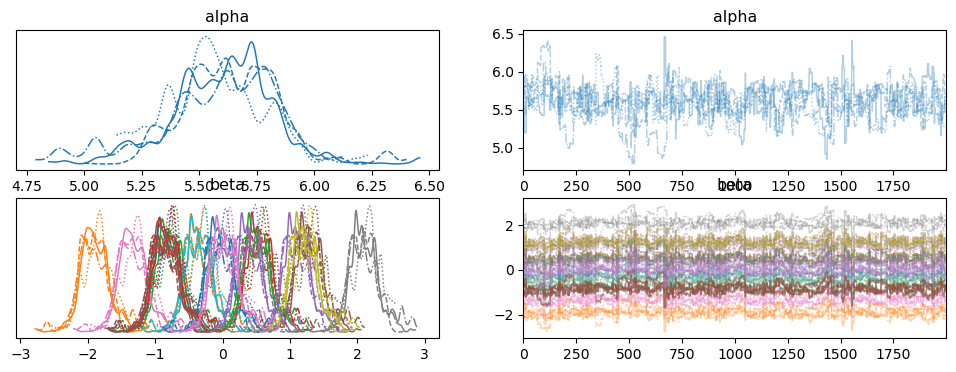

In [395]:
pm.plot_trace(h1_idata, var_names=['alpha','beta']);

c:\Users\ah140\anaconda3_\envs\prpro-2024\Lib\site-packages\xarray\core\computation.py:761: RuntimeWarning: overflow encountered in exp
  result_data = func(*input_data)


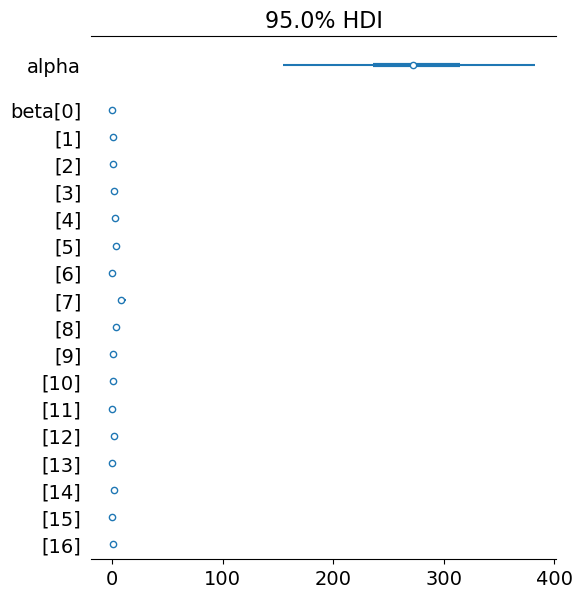

In [397]:
pm.plot_forest(h1_idata, var_names=['alpha','beta'], hdi_prob=.95, combined=True, transform=transform_exp);

#### Posterior Predictive Check

We first compute emperical mean bugs for each langauge.

In [93]:
#Calculate emperical mean of every language. Use for-loop instead of 'groupby' to maintain index order.
languages_mean = []
for language in languages:
    language_mean = df[df['language']==language]['bugs'].mean()
    languages_mean.append(language_mean)
languages_mean = pd.Series(languages_mean, index=languages)

We then calculate posterior predictive checks for each language. 

In [226]:
with h1_model:
    pm.set_data({'language_ids': np.array(range(len(languages)))}) #
    ppc = pm.sample_posterior_predictive(h1_idata, var_names=["lam"])["posterior_predictive"]["lam"]
p_mu = np.array(ppc.mean(["chain", "draw"])) #Take mean
p_mu = pd.Series(p_mu, index=languages) #convert to series with same index as languages_mean

Sampling: []


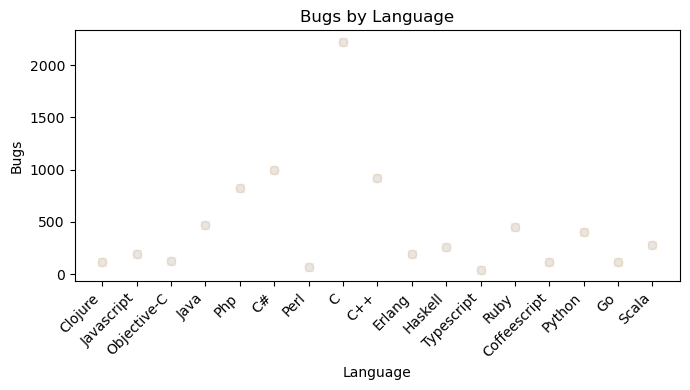

In [343]:
plt.figure(figsize=(7, 4))
plt.scatter(languages_mean.index, languages_mean, alpha=0.1, marker='o')
plt.scatter(languages_mean.index, p_mu, alpha=0.1, marker='s')
plt.title('Bugs by Language')
plt.xlabel('Language')
plt.ylabel('Bugs')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

## Hypothesis 2

* **H2** - Age (A) has a positive impact on number of bugs (B) for all programming languages (L). That is, projects of old age (A) have larger number of bugs (B). 

Like in **H1** We model the number of bugs $B$ with a Poisson distribution.

$$
B_i \sim \mathrm{Poisson}(\lambda_i)
$$

This means that the log-link function is used to connect $\lambda$ to the predictors. We use standardized Age $A$ as a continious predictor. We also add an intercept $\alpha$.

$$
log(\lambda_i) = \alpha + \beta_{A}A_i
$$

The priors for $\alpha$ and $\beta_{A}$ are not yet defined. In the following sections we determine reasonable priors for them.

$$
\alpha = \text{Not determined yet}
$$

$$
\beta_{A} = \text{Not determined yet}
$$

#### Determine prior for $\alpha$

Using the log-link function changes the outcome scale, which in turn has an effect on the priors. We therefore have to be careful when defining the priors, because the outcome scale of the prior is not linear. 

To simulate and explore the effects of possible priors for $\alpha$, we create a model that only contains $\alpha$ and does not include $\beta_{A}$

$$
B_i \sim \mathrm{Poisson}(\lambda_i)
$$

$$
ln(\lambda_i) = \alpha 
$$


$$
\alpha = \text{Not determined yet}
$$


In [183]:
def prior_predictive_check_alpha(alpha_mu_prior, alpha_sigma_prior):
    with pm.Model() as model:
        alpha = pm.Normal("alpha", mu=alpha_mu_prior, sigma=alpha_sigma_prior)
        lam = pm.Deterministic('lam', pm.math.exp(alpha))
        B = pm.Poisson('B', mu=lam, observed=df.bugs)
        
        trace = pm.sample_prior_predictive(samples=500)
        
    return trace, model

When using standardized age, $\alpha$ corresponds the $ln(\lambda)$ when age is equal to mean age. 

In the prior predictive check, we want $\alpha$ to generate a density for number of commits classified as bugs $B$ that is within a reasonable range. From our experience with GitHub, we have rarely had more than 100 commits on a project. But we also think that other projects are likely to have many more commits.   

We explore possible values for $\alpha$ by plotting the density of alpha using the prior predictive check.

Sampling: [B, alpha]


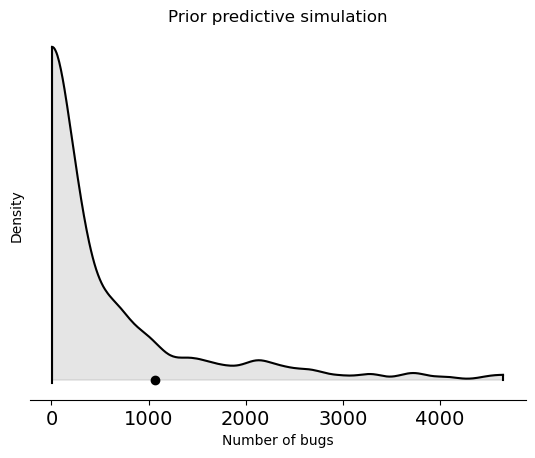

In [185]:
h1_alpha_idata, h1_alpha_model = prior_predictive_check_alpha(6,1.5)

az.plot_density(
    h1_alpha_idata.prior['lam'],
    colors='black',
    hdi_prob=0.95,
    point_estimate='mean',
    shade=0.1)
plt.title('Prior predictive simulation')
plt.xlabel('Number of bugs')
plt.ylabel('Density');

We define the prior for $\alpha$ to be $\mathcal{N}(6, 1.5)$.

This seems like a reasonable prior. It assings the expectation of $\alpha$ to be around 1000 bugs, while also assigning high probability to fewer than 1000 bugs.

#### Determine prior for $\beta_A$ 

Next, we determine the prior for $\beta_A$.

We use standardized age, which makes the coefficients easier to interpret.

In [450]:
df['age_std'] = standardize_column(df['age'])

We simulate the effect of varying the prior for $\beta_{A}$ by sampling N alphas with the fixed prior that we determined earlier, and sampling N betas where we can vary the prior.

We then plot the effect of $\beta_{A}$ by varying standardized age from -3 to 3, corresponding to 3 standard deviations below and above the mean of age. We can then see how strong or not strong the prior effect of $\beta_{A}$ on number of bugs is.

In [316]:
#Inspiration from https://github.com/pymc-devs/pymc-resources/blob/main/Rethinking_2/Chp_11.ipynb

def plot_prior_continious(b_mean: int = 0, b_std: int = 0, N: int = 100):
    plt.figure()
        
    alphas = np.random.normal(6, 1.5, N)
    betas = np.random.normal(b_mean, b_std, N)
    
    x_seq_std = np.linspace(-3, 3, N) # on std. scale
    
    for a, b in zip(alphas, betas):
        plt.plot(x_seq_std, np.exp(a + b * x_seq_std), "k", alpha=0.4)
    plt.xlabel("Age (std)")
    plt.ylabel('Number of bugs')
    
    return plt

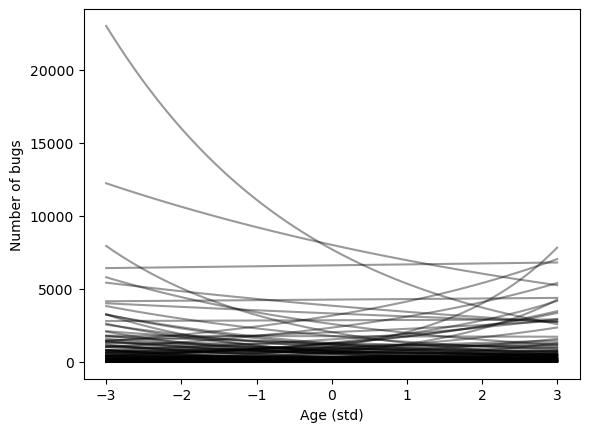

In [209]:
plot_prior_continious(0, .3);

These effects of age seem plausible. They allow for both positive and negative impact of age on the number of bugs. Many of them are rather flat, representing a conservative prior, meaning that we dont expect a particular direction of the effect of age. But we also dont expect explosive effects of age. 


We determine the prior to be $\beta_A \sim \mathcal{N}(0, 0.3)$

#### Fit model

In [210]:
def create_model_h2(alpha_mu_prior, alpha_sigma_prior, beta_mu_prior, beta_sigma_prior, save_name='', save=False):
  '''
  Creates model for hypothesis 2. 
  '''
  with pm.Model() as model:
    #Priors  
    alpha = pm.Normal('alpha', mu=alpha_mu_prior, sigma=alpha_sigma_prior)
    beta_age = pm.Normal('beta_age', mu=beta_mu_prior, sigma=beta_sigma_prior)
    
    #We add age_std here so we can do predictive plots with it later
    age_std = pm.Data("age_std", df.age_std, mutable=True)
    
    lam = pm.Deterministic('lam', pm.math.exp(alpha + beta_age * age_std))
    B = pm.Poisson('B', mu=lam, observed=df.bugs)
      
    #Sample posterior and prior predictive
    trace = pm.sample(2000, tune=1000, idata_kwargs={'log_likelihood': True}, chains=4)
    
    if save == True:  
        trace.to_netcdf("./traces/"+save_name+"_.nc")

  return trace, model

In [211]:
h2_idata, h2_model = create_model_h2(6, 1.5, 
                                     0, 0.3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_age]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 51 seconds.


The model has a single estimate for $\alpha$ and $\beta_A$, which determine $\lambda$ together with standardized age.

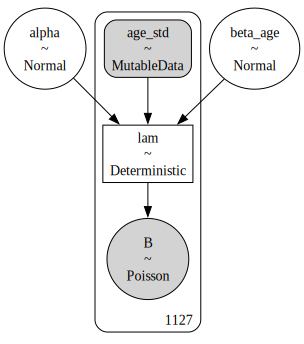

In [213]:
pm.model_to_graphviz(h2_model)

Below is the trace convergence for the parameters `alpha` and `beta_age`.

The number of generated samples is 4 chains * 2000 samples = 8000 samples.

The effective sample sizes (`ess_bulk`, `ess_tail`) approach the number of generated samples, which indicates that the samples both in the bulk and in the tails of the posteriors have low-autocorrelation. This means most of the generated samples are sufficiently different from the previous sample, thereby adding information about the posterior, leading to high accuracy of each chain.


We also note that the Monte Carlo Standard Error `msce_mean` and `msce_sd` are $0.0$, which also indicates good accuracy in the chains.

In addition, both the rhat values `r_hat` are $1.0$, which means that the 4 chains have converged well. This is also reflected in the plot below, which shows good mixing of the chains.

In summary, the convergence of the trace for model 2 is good and shows no signs of inefficient of inaccuracte sampling. We can therefore use the posterior distributions with high confidence.

In [215]:
pm.summary(h2_idata, var_names=['alpha', 'beta_age'],round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,6.08,0.0,6.08,6.09,0.0,0.0,6787.72,5600.91,1.0
beta_age,0.34,0.0,0.34,0.34,0.0,0.0,6819.22,5667.33,1.0


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta_age'}>,
        <Axes: title={'center': 'beta_age'}>]], dtype=object)

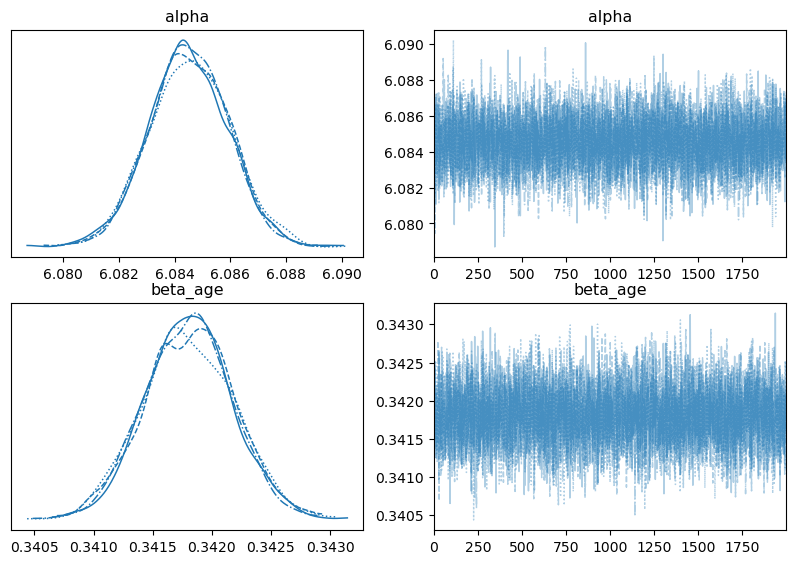

In [238]:
az.plot_trace(h2_idata, var_names = ['alpha','beta_age'], figsize=(10,6.5))

The forest plot shows that the standard deviations for the estimates for both `alpha` and `beta_age` are very small. We also note that the effect of `alpha` is much larger than the effect of `beta_age`.

The posterior mean of `alpha` is close to the prior we defined, but it has become a lot more confident - it has a posterior sd of 0.0014.

The posterior mean `beta_age` has moved in positive direction from its prior of 0. Like `alpha` the posterior sd is a lot more confident than the prior sd.

In [312]:
pm.summary(h2_idata, var_names=['alpha', 'beta_age'],round_to=4)[['mean', 'sd']]

,mean,sd
alpha,6.0845,0.0014
beta_age,0.3418,0.0004


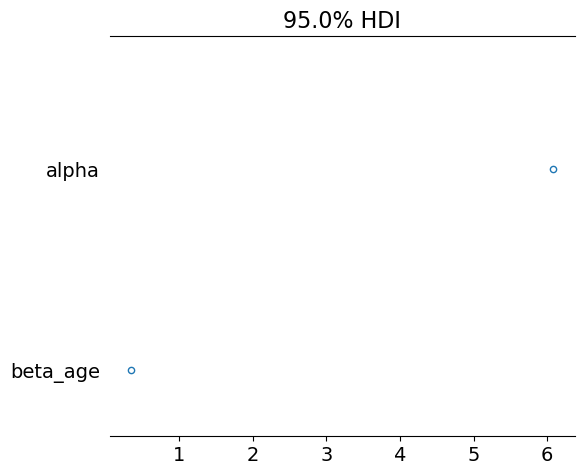

In [224]:
az.plot_forest(h2_idata, var_names = ['alpha', 'beta_age'], hdi_prob=.95, combined=True);

#### Posterior Predictive Check

Next we use the posterior estimates to make posterior predictive check and see how the model fits the data.

We calculate pareto k values for the data-points, to see influential data-points. We get a warning that some samples have a pareto k value higher than 0.7, and are therefore considered highly influential. 

In [123]:
pareto_k = az.loo(h2_idata, pointwise=True).pareto_k.values

c:\Users\ah140\anaconda3_\envs\prpro-2024\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


We sample $1.127$ points linearly from values between $-1.5$ and $14$, and use these to sample the posterior predictive estimates.

In [280]:
print(f"Min age std: {df.age_std.min():.2f}")
print(f"Max age std: {df.age_std.max():.2f}")

Min age std: -1.14
Max age std: 13.29


In [272]:
n_points = len(df)
print(f'Number of points sampled: {n_points}')
x_seq = np.linspace(-1.5, 13, n_points)

with h2_model:
    pm.set_data({"age_std": x_seq})
    post_pred_lam_h2 = pm.sample_posterior_predictive(h2_idata, var_names=["B"])['posterior_predictive']['B']
    
post_pred_lam_h2_mean = post_pred_lam_h2.mean(["chain", "draw"])

Number of points sampled: 1127


Sampling: [B]


c:\Users\ah140\anaconda3_\envs\prpro-2024\Lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


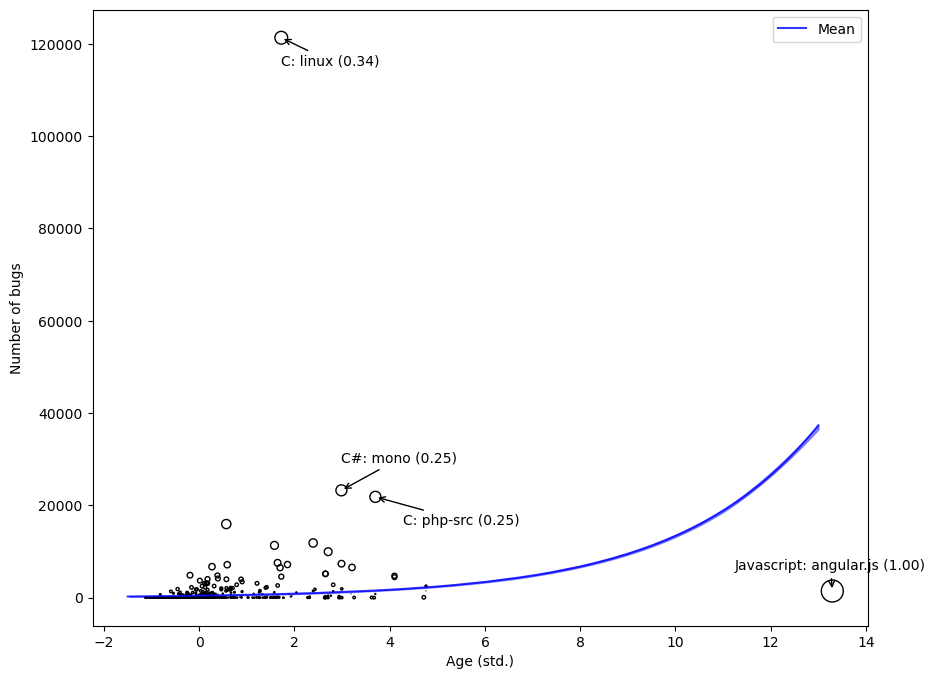

In [494]:
plt.figure(figsize=(10,8))

#scale pareto-k values by their max and changing make them nice to plot
pareto_k /= pareto_k.max()
pareto_k_size = 250 * pareto_k

#Get the 10 data points with the largest pareto_k_values
top_indices = np.argsort(pareto_k)[-10:][::-1]
top_data_points = df.iloc[top_indices]

az.plot_hdi(x_seq, post_pred_lam_h2, color = 'b', fill_kwargs={'alpha': 0.4}, ax=plt)
plt.plot(x_seq, post_pred_lam_h2_mean, color = 'b', alpha=0.8, label='Mean')
plt.scatter(df.age_std, df.bugs, s = pareto_k_size, facecolors='none', edgecolors='k', lw=1)

#Plotting text for data points with high pareto-k values. We manually adjust the place for the text.
for index, row in top_data_points.iterrows():
    dont_annotate = False
    if row['language'] == 'C' and row['project'] == 'linux':
        position=(0,-20)
    elif row['language'] == 'Javascript':
        position=(-70,15)
    elif row['language'] == 'C#' and row['project'] == 'mono':
        position=(0,20)
    elif row['language'] == 'C' and row['project'] == 'php-src':
        position=(20,-20)
    else:
        dont_annotate = True
    if dont_annotate == False:
        plt.annotate(f"{row['language']}: {row['project']} ({pareto_k[index]:.2f})", xy=(row['age_std'], row['bugs']), xytext=position,
                    textcoords='offset points', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))

plt.legend();
plt.xlabel('Age (std.)');
plt.ylabel('Number of bugs');

What jumps out of this figure is the existance of very influential data-points. In particular *C: Linux* which has many more bugs for its age compared to the other data-points, and *Javascript: angular.js* which is an old project but still has few bugs. It is inportant to note that should not discard these data-points.

However, to better vizualise the posterior predictions we "zoom in" on the data-points by removing the influential data-points from the figure.

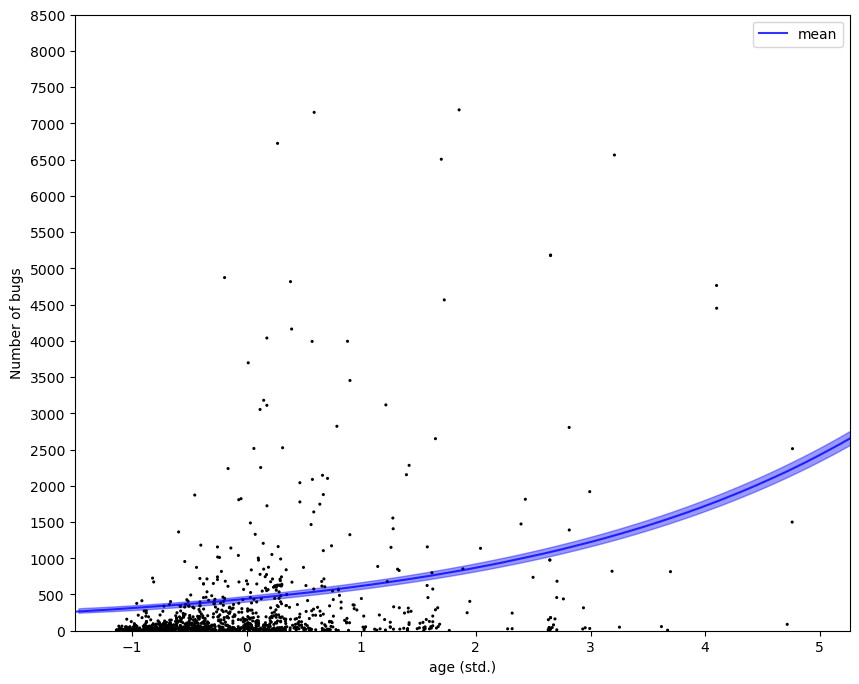

In [493]:
plt.figure(figsize=(10,8))


pareto_k_size_without_top = np.delete(pareto_k_size, top_indices)
df_without_top = df.drop(top_indices)

az.plot_hdi(x_seq, post_pred_lam_h2, color = 'b', fill_kwargs={'alpha': 0.4}, ax=plt)
plt.plot(x_seq, post_pred_lam_h2_mean, color = 'b', alpha=0.8, label='mean')
plt.scatter(df_without_top.age_std, df_without_top.bugs, facecolors='none', s=1.5, edgecolors='k', lw=1)

plt.legend()
plt.xlim(-1.5, max(df_without_top.age_std)+0.5)
plt.ylim(0,8500)
plt.xlabel('age (std.)')
plt.ylabel('Number of bugs')
plt.yticks(np.arange(0, 9000, 500));

We see a positive effect of langauge, which was also reflected in the posterior estimate of `beta_age` which was 0.34. In addition we see that the number of bugs is around 500 when standardized age is 0. This is given by the `alpha` = 6.08 which corresponds to $exp(6.08) = 437$.

The plot also shows small uncertainty of the mean, although the uncertainty grows slighly as standardized age increases. 

## Hypothesis 3

As before we model the number of bugs $B$ with a Poisson distribution.

$$
B_i \sim \mathrm{Poisson}(\lambda_i)
$$

This means that the log-link function is used to connect $\lambda$ to the predictors. We use standardized Age $A$ and standardized commits $C$ as a continious predictors. We also add an intercept $\alpha$.

$$
log(\lambda_i) = \alpha + \beta_{A}A_i + \beta_{C}C_i
$$

We re-use the prior for $\alpha$ and  $\beta_A$ that we determined in **H2**.

$$
\alpha \sim \mathcal{N}(6, 1.5)
$$

$$
\beta_A \sim \mathcal{N}(0, 0.3)
$$

We determine the prior for $\beta_{C}$ in the following section.

$$
\beta_C = \text{Not determined yet}
$$

#### Determine prior for $\beta_C$ 

We use standardized commits, which makes the coefficients easier to interpret.

In [451]:
df['commits_std'] = standardize_column(df['commits'])

In the prior for $\beta_A$ we allowed for both positive and negative impact of age on the number of bugs, with many priors being quite flat.

We dont want the same behavior in the prior for the effect of number of commits on number of bugs: $\beta_C$. This is because we know that bugs is defined as the number of commits classified as bugs. This means that commits can *not* have a negative impact on the number of bugs. This is simply impossible. So we want a prior for $\beta_C$ that only allows positive relationships.

We choose to use a log-normal distribution for $\beta_C$ which only has positive values.

In [395]:
def plot_prior_continuous_lognormal(b_mean: float = 0, b_std: float = 0, N: int = 100):
    plt.figure()
        
    alphas = np.random.normal(6, 1.5, N)
    betas = np.random.lognormal(mean=b_mean, sigma=b_std, size=N)
    x_seq_std = np.linspace(-3, 3, N) # on std. scale
    
    for a, b in zip(alphas, betas):
        plt.plot(x_seq_std, np.exp(a + b * x_seq_std), "k", alpha=0.4)
    plt.xlabel("commits (std)")
    plt.ylabel('Number of bugs')
    
    return plt

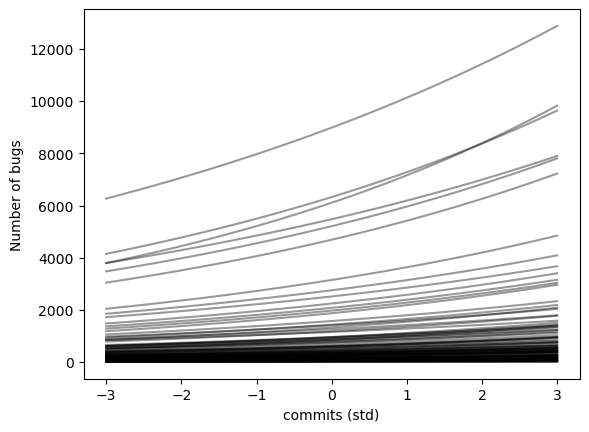

In [444]:
plot_prior_continuous_lognormal(b_mean=-2, b_std=0.1);

These effects of commits seem plausible. They are all positive, and some of them allow for very strong relationships.

We determine the prior to be $\beta_C \sim \text{LogNormal}(-2, 0.1)$.

#### Fit model

In [461]:
def create_model_h3(alpha_mu_prior, alpha_sigma_prior, beta_age_mu_prior, beta_age_sigma_prior, beta_com_mu_prior, beta_com_sigma_prior, save_name='', save=False):
  '''
  Creates model for hypothesis 3. 
  '''
  with pm.Model() as model:
    #Priors  
    alpha = pm.Normal('alpha', mu=alpha_mu_prior, sigma=alpha_sigma_prior)
    beta_age = pm.Normal('beta_age', mu=beta_age_mu_prior, sigma=beta_age_sigma_prior)
    beta_com = pm.Lognormal('beta_com', mu=beta_com_mu_prior, sigma=beta_com_sigma_prior)
    
    #We add age_std and com_std here so we can do predictive plots with it later
    age_std = pm.Data("age_std", df.age_std, mutable=True)
    com_std = pm.Data("com_std", df.commits_std, mutable=True)
    
    lam = pm.Deterministic('lam', pm.math.exp(alpha + beta_com*com_std + beta_age*age_std))
    B = pm.Poisson('B', mu=lam, observed=df.bugs)
      
    #Sample posterior and prior predictive
    trace = pm.sample(2000, tune=1000, idata_kwargs={'log_likelihood': True}, chains=4)
    
    if save == True:  
        trace.to_netcdf("./traces/"+save_name+"_.nc")

  return trace, model

In [462]:
h3_idata, h3_model = create_model_h3(6, 1.5,
                                     0, 0.3,
                                     -2, 0.1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_age, beta_com]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 65 seconds.


The model has a single estimate for $\alpha$, $\beta_A$ and $\beta_C$, which determine $\lambda$ together with standardized age and standarsized commits.

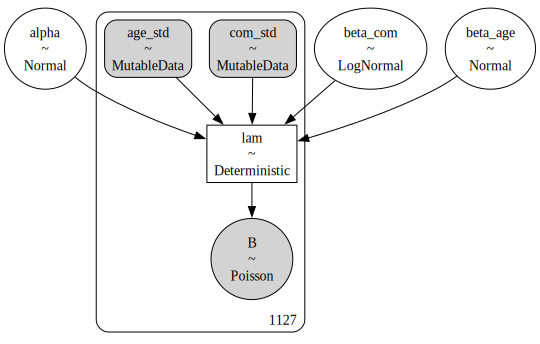

In [463]:
pm.model_to_graphviz(h3_model)

Below is the trace convergence for the parameters `alpha`,  `beta_age`, and `beta_com`

The number of generated samples is 4 chains * 2000 samples = 8000 samples.

The effective sample sizes (`ess_bulk`, `ess_tail`) approach the number of generated samples, which indicates that the samples both in the bulk and in the tails of the posteriors have low-autocorrelation. This means most of the generated samples are sufficiently different from the previous sample, thereby adding information about the posterior, leading to high accuracy of each chain.

We also note that the Monte Carlo Standard Error `msce_mean` and `msce_sd` are $0.0$, which also indicates good accuracy in the chains.

In addition, both the rhat values `r_hat` are $1.0$, which means that the 4 chains have converged well. This is also reflected in the plot below, which shows good mixing of the chains.

In summary, the convergence of the trace for model 3 is good and shows no signs of inefficient of inaccuracte sampling. We can therefore use the posterior distributions with high confidence.

In [464]:
pm.summary(h3_idata, var_names=['alpha', 'beta_age', 'beta_com'],round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,5.82,0.0,5.81,5.82,0.0,0.0,5486.81,6030.01,1.0
beta_age,0.33,0.0,0.32,0.33,0.0,0.0,6195.19,5383.60,1.0
beta_com,0.17,0.0,0.17,0.17,0.0,0.0,6200.61,6115.41,1.0


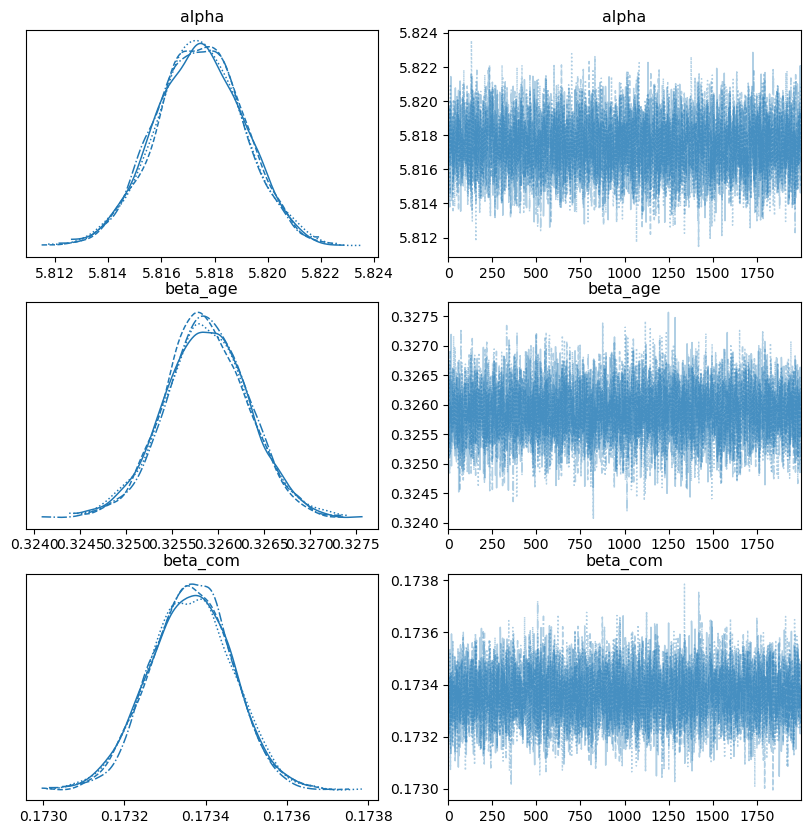

In [465]:
az.plot_trace(h3_idata, var_names = ['alpha','beta_age', 'beta_com'], figsize=(10,10));

The forest plot shows that the standard deviations for the estimates for both `alpha`, `beta_age`, and `beta_com` are very small. We also note that the effect of `alpha` is much larger than the effect of `beta_age` and `beta_com`.

Contrary to what we expected, `beta_age` actually has a larger effect than `beta_com`. We expected `beta_com` to have a larger effect because it is so closely associated with number of bugs. 

In [467]:
pm.summary(h3_idata, var_names=['alpha', 'beta_age', 'beta_com'],round_to=4)[['mean', 'sd']]

,mean,sd
alpha,5.8174,0.0016
beta_age,0.3259,0.0005
beta_com,0.1734,0.0001


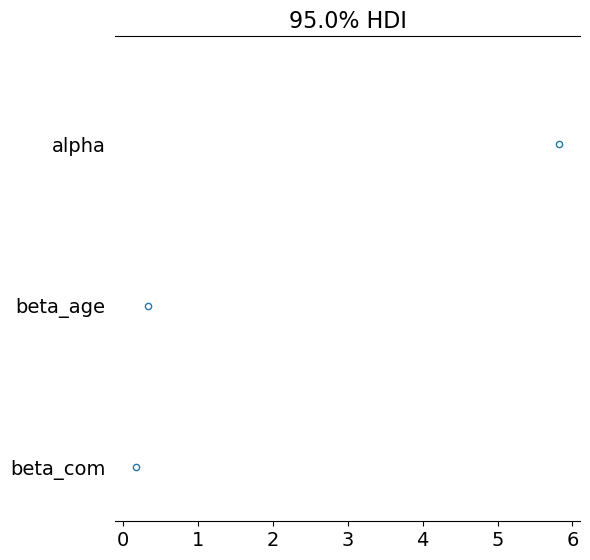

In [460]:
az.plot_forest(h3_idata, var_names = ['alpha','beta_age', 'beta_com'], hdi_prob=.95, combined=True);

Next we compare the effect of age on number of bugs without conditioning on the number of commits (H2) and with conditioning on the number of commits (H3). 

We see a notable difference between the effect of age in the two models. The effect of age on the number of bugs conditioned by the number of commits is confidently lower than the direct effect of age. 

Nonetheless, the difference seems quite small when looking at the estimates. It will be easier to compare in the next section of posterior predictions.

In [480]:
print(f"Decrease in posterior mean of beta_age from H2 to H3: {round(pm.summary(h3_idata, var_names=['beta_age'],round_to=4)['mean'].values[0]-pm.summary(h2_idata, var_names=['beta_age'],round_to=4)['mean'].values[0], 4)}")

Decrease in posterior mean of beta_age from H2 to H3: -0.0159


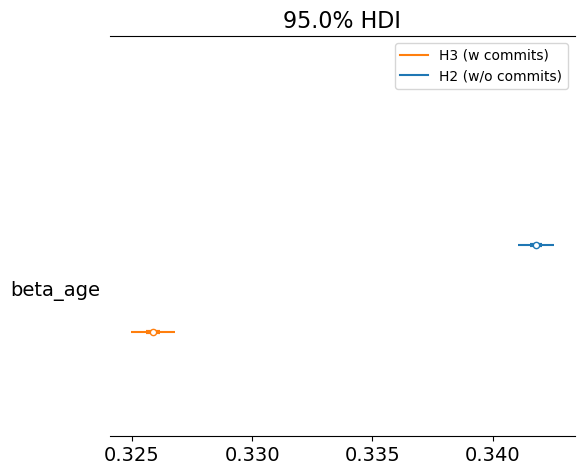

In [483]:
az.plot_forest(
    data=[h2_idata, h3_idata],
    model_names = ['H2 (w/o commits)','H3 (w commits)'],
    var_names=['beta_age'],
    hdi_prob=.95,
    combined=True);

#### Posterior Predictive Check

We calculate pareto k values for the data-points, to see influential data-points. We get the same warning as in H2.

In [486]:
pareto_k = az.loo(h3_idata, pointwise=True).pareto_k.values

c:\Users\ah140\anaconda3_\envs\prpro-2024\Lib\site-packages\arviz\stats\stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
c:\Users\ah140\anaconda3_\envs\prpro-2024\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


For standardized age, we sample $1.127$ points linearly from values between $-1.5$ and $14$, exactly like in H2.

For standardized commits, we sample $1.127$ points of 0. This is simply to remove the effect of `beta_com`.

This means that we can compare the posterior predictions of the model in H3 with the model in H2 when varying standardized age.

In [487]:
n_points = len(df)
print(f'Number of points sampled: {n_points}')
x_seq = np.linspace(-1.5, 13, n_points)

with h3_model:
    pm.set_data({"age_std": x_seq, "com_std": np.repeat(0, n_points)})
    post_pred_lam_h3 = pm.sample_posterior_predictive(h3_idata, var_names=["B"])['posterior_predictive']['B']
    
post_pred_lam_h3_mean = post_pred_lam_h3.mean(["chain", "draw"])

Number of points sampled: 1127


Sampling: [B]


We remove the influential data-points from the figure so it is easier to compare the two models.

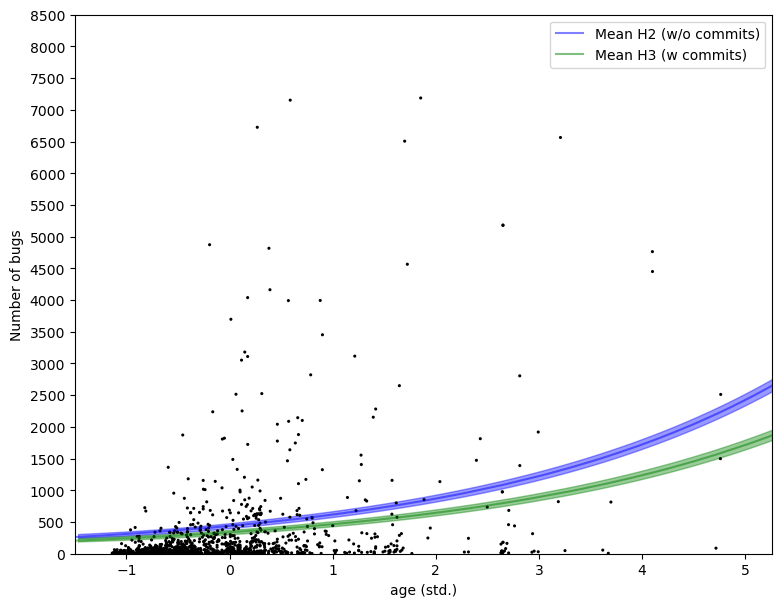

In [491]:
plt.figure(figsize=(9,7))


pareto_k_size_without_top = np.delete(pareto_k_size, top_indices)
df_without_top = df.drop(top_indices)

az.plot_hdi(x_seq, post_pred_lam_h2, color = 'b', fill_kwargs={'alpha': 0.4}, ax=plt)
plt.plot(x_seq, post_pred_lam_h2_mean, color = 'b', alpha=0.5, label='Mean H2 (w/o commits)')

az.plot_hdi(x_seq, post_pred_lam_h3, color = 'g', fill_kwargs={'alpha': 0.4}, ax=plt)
plt.plot(x_seq, post_pred_lam_h3_mean, color = 'g', alpha=0.5, label='Mean H3 (w commits)')


plt.scatter(df_without_top.age_std, df_without_top.bugs, facecolors='none', s=1.5, edgecolors='k', lw=1)

plt.legend()
plt.xlim(-1.5, max(df_without_top.age_std)+0.5)
plt.ylim(0,8500)
plt.xlabel('age (std.)')
plt.ylabel('Number of bugs')
plt.yticks(np.arange(0, 9000, 500));

* **H3** - Number of commits (C) does not impact the effect of age (A) on the number of bugs (B) for any programming language (L). That is, the effect of age (A), conditioned on number of commits (C), on number of bugs (B) is the same as the direct effect of age (A) on number of bugs (B).

The blue line corresponds to the effect of age in model 2 is the same as in the previous figure, and is the direct effect of age on number of bugs. The green line is the effect of age conditioned on the number of commits. 

The alpha for model 3 is slightly lower than the alpha for model 2. Subtracting the exponential of their posterior means gives a difference of $exp(6.08) - exp(5.82)$=100.



We see a positive effect of langauge, which was also reflected in the posterior estimate of `beta_age` which was 0.34. In addition we see that the number of bugs is around 500 when standardized age is 0. This is given by the `alpha` = 6.08 which corresponds to $exp(6.08) = 437$.

The plot also shows small uncertainty of the mean, although the uncertainty grows slighly as standardized age increases. 

## Use information criteria to compare the models to analyze H1, H2 and H3.

In [495]:
pm.compare({'h1': h1_idata,
            'h2': h2_idata,
            'h3': h3_idata})

c:\Users\ah140\anaconda3_\envs\prpro-2024\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
c:\Users\ah140\anaconda3_\envs\prpro-2024\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
c:\Users\ah140\anaconda3_\envs\prpro-2024\Lib\si

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
h3,0,-5.299360e+05,3541.924231,0.000000,0.333333,73014.532093,0.000000,True,log
h1,1,-9.664739e+05,20784.899662,436537.870651,0.333333,261130.963350,247390.903001,True,log
h2,2,-1.120007e+06,4563.390987,590071.323124,0.333333,497875.108067,489718.121260,True,log


## Multilevel Model

In [575]:
df.groupby('project_type')['bugs'].mean()

project_type
Application      301.995146
CodeAnalyzer     361.913043
Database         394.682540
Framework        443.934169
Library          412.577869
Middleware      2034.457143
Other            489.206897
Name: bugs, dtype: float64

In [602]:
project_types_idx, project_types = pd.factorize(df.project)

In [604]:
def create_model_h2_nopooling(alpha_mu_prior, alpha_sigma_prior, beta_mu_prior, beta_sigma_prior, save_name='', save=False):
  '''
  Creates model for hypothesis 2. 
  '''
  
  with pm.Model() as model:
    #Priors  
    alpha = pm.Normal('alpha', mu=alpha_mu_prior, sigma=alpha_sigma_prior, shape=project_types.size)
    beta_age = pm.Normal('beta_age', mu=beta_mu_prior, sigma=beta_sigma_prior)
    
    #We add age_std and project_types_ids here so we can do predictive plots with it later
    age_std = pm.Data("age_std", df.age_std, mutable=True)
    project_types_ids = pm.Data('project_types_idx', project_types_idx, mutable=True)
    
    lam = pm.Deterministic('lam', pm.math.exp(alpha[project_types_ids] + beta_age * age_std))
    B = pm.Poisson('B', mu=lam, observed=df.bugs)
      
    #Sample posterior and prior predictive
    trace = pm.sample(2000, tune=1000, idata_kwargs={'log_likelihood': True}, chains=4)
    
    if save == True:  
        trace.to_netcdf("./traces/"+save_name+"_.nc")

  return trace, model

In [605]:
h2_nopooling_idata, h2_nopooling_model = create_model_h2_nopooling(6, 1, 0.01, 0.3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_age]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 284 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


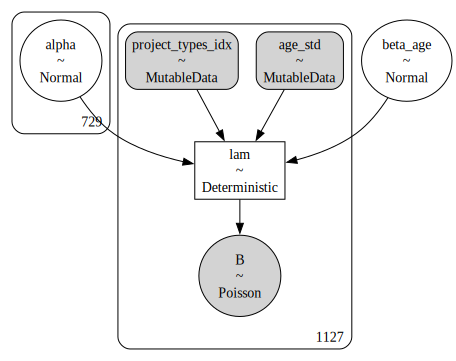

In [606]:
pm.model_to_graphviz(model=h2_nopooling_model)

In [607]:
pm.summary(h2_nopooling_idata, var_names=['alpha', 'beta_age'],round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],9.86,0.08,9.70,10.01,0.0,0.0,7211.82,5280.02,1.00
alpha[1],13.10,0.13,12.86,13.33,0.0,0.0,5907.08,5477.45,1.00
alpha[2],9.07,0.05,8.97,9.16,0.0,0.0,6011.06,5756.74,1.00
alpha[3],14.63,0.13,14.38,14.88,0.0,0.0,3122.25,4542.04,1.00
alpha[4],8.97,0.08,8.82,9.12,0.0,0.0,10825.84,5439.69,1.00
...,...,...,...,...,...,...,...,...,...
alpha[725],4.09,0.02,4.06,4.13,0.0,0.0,199.99,1119.45,1.03
alpha[726],11.44,0.06,11.33,11.57,0.0,0.0,1132.54,4111.75,1.01
alpha[727],6.81,0.07,6.67,6.95,0.0,0.0,12430.92,4954.32,1.00
alpha[728],9.93,0.34,9.31,10.56,0.0,0.0,12409.26,5424.47,1.00


c:\Users\ah140\anaconda3_\envs\prpro-2024\Lib\site-packages\xarray\core\computation.py:761: RuntimeWarning: overflow encountered in exp
  result_data = func(*input_data)


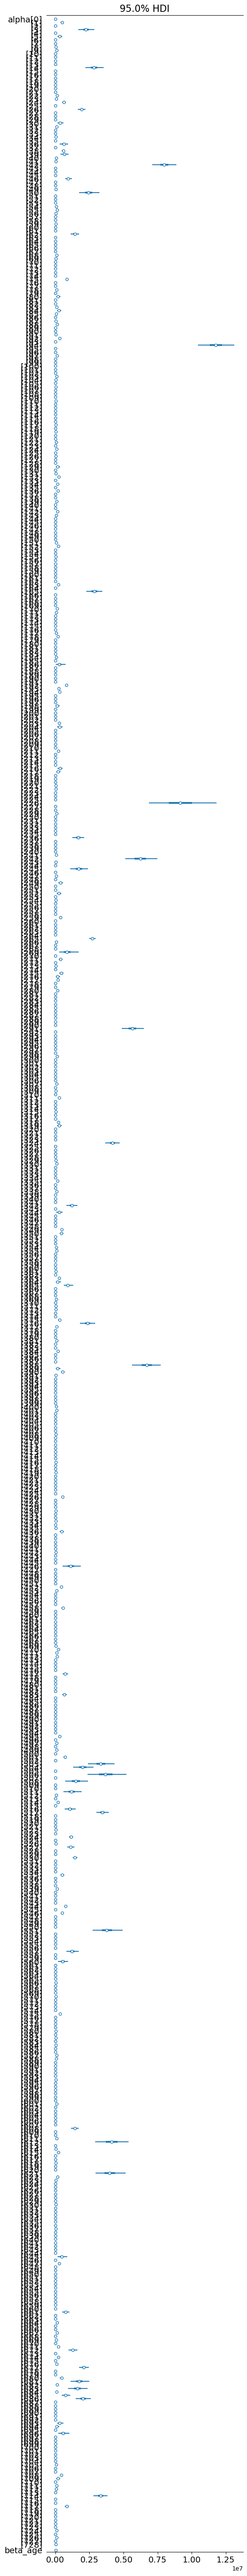

In [608]:
az.plot_forest(h2_nopooling_idata, var_names = ['alpha','beta_age'], hdi_prob=.95, combined=True, transform=transform_exp);

In [610]:
def create_model_h2_multilevel(beta_mu_prior, beta_sigma_prior, save_name='', save=False):
  '''
  Creates model for hypothesis 2. 
  '''
  with pm.Model() as model:
    #Hyperpriors
    alpha_sigma_prior = pm.Exponential('alpha_sigma_prior', lam=1)
    alpha_mu_prior = pm.Normal('alpha_mu_prior', mu=0.01, sigma=1)  
      
    #Priors  
    alpha = pm.Normal('alpha', mu=alpha_mu_prior, sigma=alpha_sigma_prior, shape=project_types.size)
    beta_age = pm.Normal('beta_age', mu=beta_mu_prior, sigma=beta_sigma_prior)
    
    #We add age_std and project_types_ids here so we can do predictive plots with it later
    age_std = pm.Data("age_std", df.age_std, mutable=True)
    project_types_ids = pm.Data('project_types_idx', project_types_idx, mutable=True)
    
    lam = pm.Deterministic('lam', pm.math.exp(alpha[project_types_ids] + beta_age * age_std))
    B = pm.Poisson('B', mu=lam, observed=df.bugs)
      
    #Sample posterior and prior predictive
    trace = pm.sample(2000, tune=1000, idata_kwargs={'log_likelihood': True}, chains=4)
    
    if save == True:  
        trace.to_netcdf("./traces/"+save_name+"_.nc")

  return trace, model

In [611]:
h2_multilevel_idata, h2_multilevel_model = create_model_h2_multilevel(6, 1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_sigma_prior, alpha_mu_prior, alpha, beta_age]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1681 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


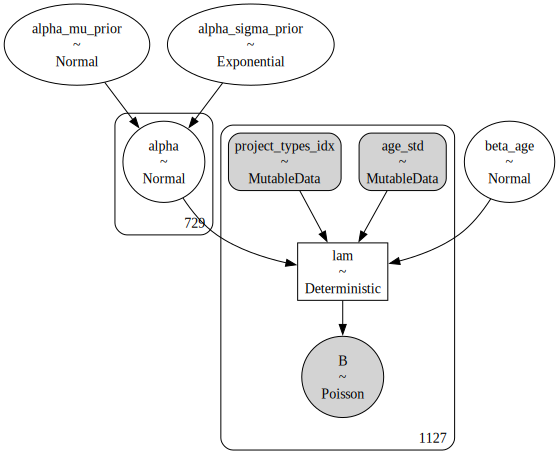

In [612]:
pm.model_to_graphviz(model=h2_multilevel_model)

In [621]:
pm.summary(h2_multilevel_idata, var_names=['alpha', 'beta_age', 'alpha_sigma_prior', 'alpha_mu_prior'], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],18.29,0.36,17.79,18.98,0.17,0.13,4.74,17.10,2.56
alpha[1],28.33,0.65,27.42,29.52,0.32,0.24,4.66,15.96,2.71
alpha[2],14.31,0.23,13.99,14.73,0.11,0.08,4.75,16.65,2.56
alpha[3],32.70,0.77,31.66,34.12,0.37,0.29,4.62,14.20,2.79
alpha[4],15.67,0.29,15.24,16.22,0.14,0.11,4.87,19.44,2.40
...,...,...,...,...,...,...,...,...,...
alpha[727],10.63,0.18,10.36,10.97,0.08,0.06,5.32,23.09,2.03
alpha[728],24.62,0.67,23.54,25.92,0.30,0.23,5.48,25.24,1.95
beta_age,29.20,0.78,28.17,30.58,0.38,0.29,4.46,14.17,3.18
alpha_sigma_prior,25.62,1.00,23.88,27.58,0.37,0.27,7.60,32.60,1.48


c:\Users\ah140\anaconda3_\envs\prpro-2024\Lib\site-packages\xarray\core\computation.py:761: RuntimeWarning: overflow encountered in exp
  result_data = func(*input_data)


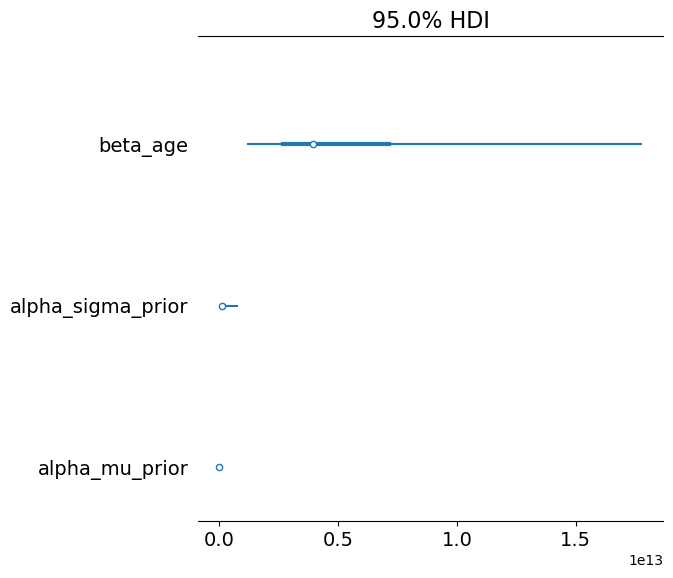

In [622]:
az.plot_forest(h2_multilevel_idata, var_names=['beta_age', 'alpha_sigma_prior', 'alpha_mu_prior'], hdi_prob=.95, combined=True, transform=transform_exp);